In [2]:
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from spectralDNS import config, get_solver, solve

In [2]:
f = h5.File("NS2D_w.h5")

In [3]:
U1 = f["U1/2D/100"][:, :]

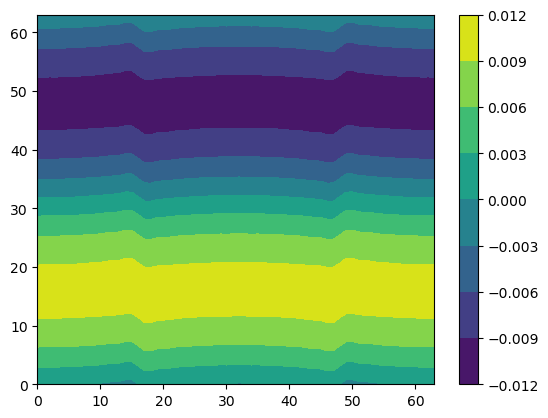

In [5]:
c = plt.contourf(U1)
plt.colorbar(c)

In [6]:
np.std(U1)*np.sqrt(2)

0.010012866050329076

In [5]:
def rms(X):
    return np.sqrt(np.mean(X**2))


def initialize(X, U, U_hat, mask, T, K, K_over_K2, **context):
    params = config.params
    N = params.N
    U[1] = params.A*np.sin(params.k*X[0])
    U[0, :, :N[1]//2] = np.tanh((X[1][:, :N[1]//2]-0.5*np.pi)/params.delta)
    U[0, :, N[1]//2:] = -np.tanh((X[1][:, N[1]//2:]-1.5*np.pi)/params.delta)

    U_hat = U.forward(U_hat)

    U_hat[:] -= (K[0]*U_hat[0]+K[1]*U_hat[1])*K_over_K2
    if solver.rank == 0:
        U_hat[:, 0, 0] = 0.0

    T.mask_nyquist(U_hat, mask)


def L2_norm(u, comm):
    N = config.params.N
    result = comm.allreduce(sum(u**2))
    return result/np.prod(N)


im, im2 = None, None
count = 0


def update(context):
    global im, im2, count
    params = config.params
    solver = config.solver
    dx, L, N = params.dx, params.L, params.N
    if params.tstep % params.compute_energy == 0:
        U = solver.get_velocity(**context)
        # div_u = solver.get_divergence(**context)
        # du = L2_norm(div_u, solver.comm)
        kk = solver.comm.reduce(np.sum(U.astype(np.float64)
                                       * U.astype(np.float64))
                                * dx[0]*dx[1]/L[0]/L[1]/2)
        if solver.rank == 0:
            print(params.tstep, kk)

    u0 = solver.get_velocity(**context)[0, :, N[1]//4]
    u0_amp = np.std(u0) * np.sqrt(2)
    u1 = solver.get_velocity(**context)[1, :, N[1]//4]
    u1_amp = np.std(u1) * np.sqrt(2)
    amp[..., params.tstep - 1] = [u0_amp, u1_amp]


if __name__ == "__main__":
    config.update(
            {
                'nu': 1.0e-10,
                'dt': 0.001,
                'T': 1.0,
                'A': 0.01,
                'delta': 0.01,
                'write_result': 100,
                'plot_result': -1,
                'compute_energy': 100,
                'N': [64, 64],
                'optimizer': 'cython',
                'amplitude_name': 'NS2D_amplitude.h5',
                'k': 1
                }, 'doublyperiodic'
            )
    solver = get_solver(update=update,
                        mesh='doublyperiodic', parse_args=["NS2D"])

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


cross1 not optimized
cross2 not optimized
RK4 not optimized
ForwardEuler not optimized
AB2 not optimized
add_pressure_diffusion not optimized


In [15]:
help(solver.get_context().VT.backward)

Help on VectorTransform in module shenfun.tensorproductspace object:

class VectorTransform(builtins.object)
 |  VectorTransform(transforms)
 |  
 |  Methods defined here:
 |  
 |  __call__(self, input_array, output_array, kind=None, **kw)
 |      Call self as a function.
 |  
 |  __getattr__(self, name)
 |  
 |  __init__(self, transforms)
 |      Initialize self.  See help(type(self)) for accurate signature.



In [9]:
solver.get_context()

{'mpitype': <mpi4py.MPI.Datatype at 0x7f894a8c5290>,
 'collapse_fourier': True,
 'V': [<shenfun.fourier.bases.C2C at 0x7f894a94ac70>,
 'kw0': {'threads': 1, 'planner_effort': 'FFTW_MEASURE'},
 'T': <shenfun.tensorproductspace.TensorProductSpace at 0x7f894a886b80>,
 'VT': <shenfun.tensorproductspace.VectorSpace at 0x7f894a886dc0>,
 'kw': {'padding_factor': 1, 'dealias_direct': True},
 'Tp': <shenfun.tensorproductspace.TensorProductSpace at 0x7f894a9af8e0>,
 'VTp': <shenfun.tensorproductspace.VectorSpace at 0x7f894a9af0a0>,
 'mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0]]),
 'X': [array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.09817477, 0.09817477, 0.09817477, ..., 0.09817477, 0.09817477,
          0.09817477],
         [0.19634954, 0.19634954, 0.19634954, ...,